In [ ]:
import calendar
import warnings
from functools import partial
from pathlib import Path
from typing import TYPE_CHECKING, Generic, TypeVar, cast

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cmo
import imageio_ffmpeg
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.distributed import Client
from matplotlib import rcParams
from matplotlib.animation import FuncAnimation
from matplotlib.collections import PathCollection
from tqdm import tqdm

if TYPE_CHECKING:
    from cartopy.mpl.geoaxes import GeoAxes
    from matplotlib.axes import Axes
    from matplotlib.figure import Figure
    from numpy.typing import NDArray

    T = TypeVar("T")

    class AxesArray(NDArray, Generic[T]):
        """Bit of a hacky class to allow for type hinting of Axes objects.

        Use with the output axs from plt.subplots as `axs = cast(AxesArray[Axes], axs)`.
        """

        def __getitem__(self, key) -> T:  # type: ignore[reportIncompatibleMethodOverride] # noqa: D105
            return super().__getitem__(key)  # type: ignore[reportReturnType]


rcParams["animation.ffmpeg_path"] = imageio_ffmpeg.get_ffmpeg_exe()


def setup_dask_client() -> Client | None:
    """Set up a Dask client for parallel processing.

    Returns:
        Client | None: The Dask client if successful, otherwise None.

    """
    try:
        client = Client()
        print(f"Dask client connected: {client.dashboard_link}")
    except Exception as e:  # noqa: BLE001
        print(f"Failed to connect to Dask client: {e}")
        return None
    return client


client = setup_dask_client()

In [ ]:
def open_parcels_output(
    path: str | Path,
    load: bool = True,  # noqa: FBT001, FBT002
) -> xr.Dataset:
    """Open a Zarr file containing OceanParcels (https://docs.oceanparcels.org/en/latest/index.html) output.

    Automatically detects if the path is a single zarr file or if it is a directory containing multiple Zarr files from MPI runs,
    as detailed here: https://docs.oceanparcels.org/en/latest/examples/documentation_MPI.html.

    Args:
        path (str or Path): Path to the Zarr file or directory containing the Zarr files.
        load (bool): If True, loads the dataset into memory. Defaults to True.

    Returns:
        ds (xr.Dataset): The dataset containing the OceanParcels output.

    Raises:
        FileNotFoundError: If the specified path does not exist.

    """
    if isinstance(path, str):
        path = Path(path)
    if not path.exists():
        msg = f"Path {path} does not exist."
        raise FileNotFoundError(msg)
    mpi_files = list(path.glob("proc*"))
    if len(mpi_files) == 0:
        ds = xr.open_zarr(path)
    else:
        ds = xr.concat(
            [xr.open_zarr(f) for f in mpi_files],
            dim="trajectory",
            compat="no_conflicts",
            coords="minimal",
        )
    if load:
        ds.load()  # Load the dataset into memory
    return ds


def convert_to_time_index(ds: xr.Dataset, save_path: Path | None = None) -> xr.Dataset:
    """Convert the 'obs' dimension to a time index.

    Args:
        ds (xr.Dataset): The dataset to convert.
        save_path (Path | None): Optional path to save the converted dataset as a Zarr file.

    Returns:
        ds (xr.Dataset): The dataset with 'obs' converted to a time index.

    """
    ds = ds.dropna(dim="obs", how="all")  # Drop observations that are all NaN
    ds["time"] = ds["time"].astype("datetime64[D]").astype("datetime64[ns]")  # Round to nearest day
    ds_list = [
        ds.isel(trajectory=i).dropna("obs").swap_dims({"obs": "time"}).drop_duplicates("time")
        for i in tqdm(ds["trajectory"], desc="Processing trajectory")
    ]
    ds = xr.concat(ds_list, dim="trajectory")
    ds["obs"] = ds["obs"].astype(np.float32)
    ds.chunk({"trajectory": -1, "time": 1})
    if save_path is not None:
        ds.to_zarr(save_path, mode="w")
        print(f"Dataset saved to {save_path}")
    return ds

In [133]:
DATA_DIR = Path("D:/nccs-transport/forward_releases/")
file = DATA_DIR / "fwd_release_140W_45-55N_1997.zarr"
ds = open_parcels_output("D:\\nccs-transport\\forward_releases\\fwd_release_140W_45-55N_1997.zarr")
ds_time = open_parcels_output("D:\\nccs-transport\\forward_releases\\fwd_release_timeidx_140W_45-55N_1997.zarr")
ds_time = ds_time.where(ds_time["age"] < 366 * 2)

In [ ]:
n_particles_per_day = int(ds_time.attrs["n_particles"])
month_lengths = [calendar.monthrange(1997, i)[1] for i in range(1, 13)]
trajectory_starts = [0] + [sum(month_lengths[:i]) * n_particles_per_day for i in range(1, 13)]
trajectory_ends = [sum(month_lengths[:i]) * n_particles_per_day for i in range(1, 13)]
trajectory_slices = [slice(ts, te) for ts, te in zip(trajectory_starts, trajectory_ends, strict=False)]
ds_jan = ds_time.isel(trajectory=trajectory_slices[0])
month_colors = [cmo.phase(i / 12) for i in range(1, 13)]  # type: ignore[reportAttributeAccessIssue]
trajectory_colors = np.concat(
    [np.full((ml * 50, 4), color) for color, ml in zip(month_colors, month_lengths, strict=True)],
)

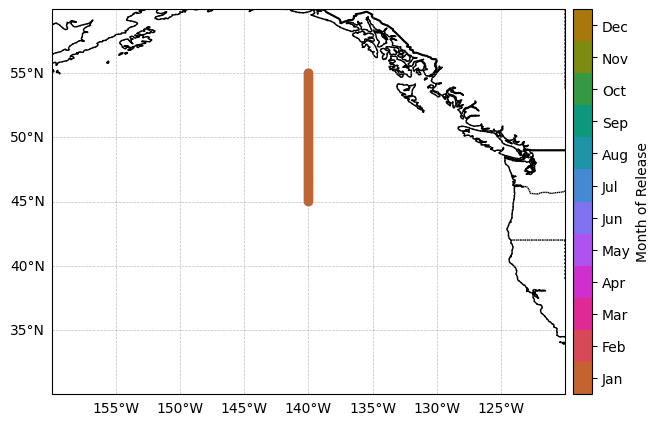

In [131]:
fig: "Figure"
ax: "GeoAxes | Axes"
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})
# Need to explicitly cast to GeoAxes for type checking, since plt.subplots doesn't return different types based on subplot_kw
ax = cast("GeoAxes", ax)

sca_data = np.array([ds_time["lon"].isel(time=0), ds_time["lat"].isel(time=0)])
sca = ax.scatter(
    sca_data[0],
    sca_data[1],
    transform=ccrs.PlateCarree(),
    c=trajectory_colors,
    rasterized=True,
)
ax.set_extent([-160, -120, 30, 60], crs=ccrs.PlateCarree())
gl = ax.gridlines(ls="--", color="gray", alpha=0.5, linewidth=0.5)
gl.bottom_labels = True
gl.left_labels = True
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=1.5)
ax.add_feature(cfeature.STATES, linestyle=":")

cmap = mcolors.LinearSegmentedColormap.from_list("colors", trajectory_colors)
norm = mcolors.BoundaryNorm(
    np.arange(0.5, 13, 1),
    cmap.N,
    clip=True,
)
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(
    mappable,
    ax=ax,
    orientation="vertical",
    label="Month of Release",
    ticks=np.arange(1, 13),
    pad=0.01,
)
cbar.ax.set_yticklabels([calendar.month_abbr[i] for i in range(1, 13)])
cbar.ax.minorticks_off()

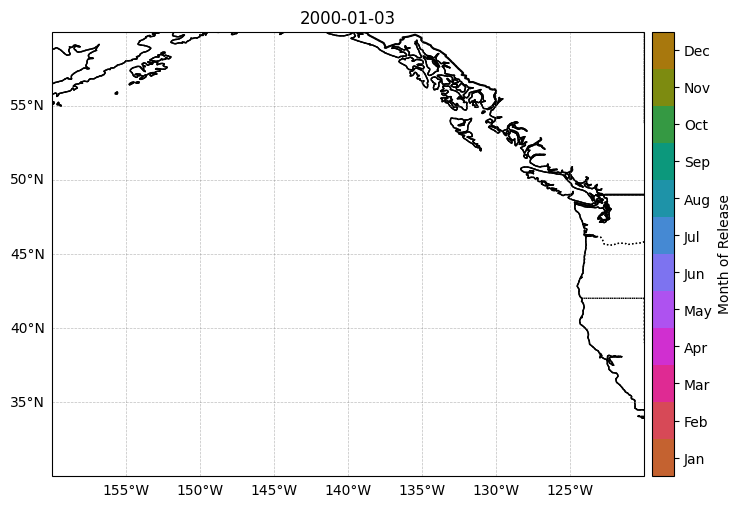

In [143]:
fig: "Figure"
ax: "GeoAxes | Axes"
fig, ax = plt.subplots(figsize=(8, 5), subplot_kw={"projection": ccrs.PlateCarree()})
fig.tight_layout(pad=2.0)
# Need to explicitly cast to GeoAxes for type checking, since plt.subplots doesn't return different types based on subplot_kw
ax = cast("GeoAxes", ax)

sca_data = np.array([ds_time["lon"].isel(time=0), ds_time["lat"].isel(time=0)])
sca = ax.scatter(
    sca_data[0],
    sca_data[1],
    transform=ccrs.PlateCarree(),
    c=trajectory_colors,
    rasterized=True,
)
ax.coastlines()
ax.set_extent([-160, -120, 30, 60], crs=ccrs.PlateCarree())

gl = ax.gridlines(ls="--", color="gray", alpha=0.5, linewidth=0.5)
gl.bottom_labels = True
gl.left_labels = True
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle="-", linewidth=1.5)
ax.add_feature(cfeature.STATES, linestyle=":")

cmap = mcolors.LinearSegmentedColormap.from_list("colors", trajectory_colors)
norm = mcolors.BoundaryNorm(
    np.arange(0.5, 13, 1),
    cmap.N,
    clip=True,
)
mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar = fig.colorbar(
    mappable,
    ax=ax,
    orientation="vertical",
    label="Month of Release",
    ticks=np.arange(1, 13),
    pad=0.01,
)
cbar.ax.set_yticklabels([calendar.month_abbr[i] for i in range(1, 13)])
cbar.ax.minorticks_off()


def init() -> tuple[PathCollection]:  # noqa: D103
    return (sca,)


def update(frame: int, sca: PathCollection) -> tuple[PathCollection]:  # noqa: D103
    sca_data = np.array([ds_time["lon"].isel(time=frame), ds_time["lat"].isel(time=frame)])
    sca.set_offsets(sca_data.T)
    time = ds_time["time"].to_numpy()[frame].astype("datetime64[D]").astype(str)
    ax.set_title(time)
    return (sca,)


ani = FuncAnimation(
    fig,
    partial(update, sca=sca),
    frames=ds_time["time"].size,
    init_func=init,
    blit=True,
    interval=50,
)

ani.save("1997_release_animation.mp4", writer="ffmpeg")

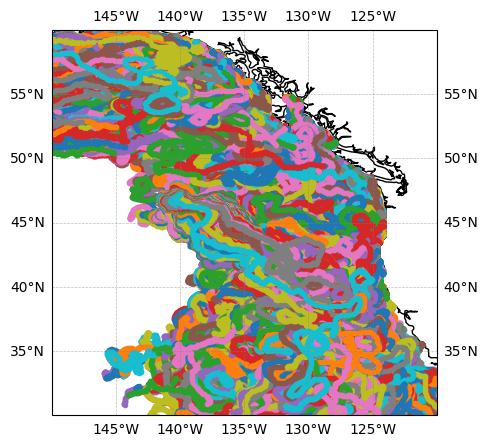

In [19]:
fig: "Figure"
ax: "GeoAxes | Axes"
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})
# Need to explicitly cast to GeoAxes for type checking, since plt.subplots doesn't return different types based on subplot_kw
ax = cast("GeoAxes", ax)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in linestrings")
    ax.plot(
        ds.lon.T,
        ds.lat.T,
        transform=ccrs.PlateCarree(),
        marker=".",
    )

ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-150, -120, 30, 60], crs=ccrs.PlateCarree())

ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")

In [80]:
files = list(DATA_DIR.glob("*.zarr"))
ds = [open_parcels_output(f) for f in files]
len(ds)

3

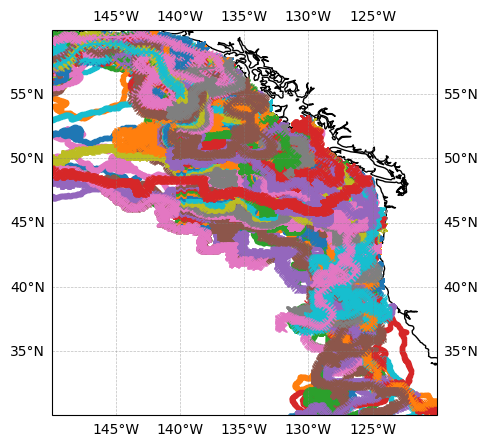

In [87]:
fig: "Figure"
ax: "GeoAxes | Axes"
fig, ax = plt.subplots(figsize=(10, 5), subplot_kw={"projection": ccrs.PlateCarree()})
ax = cast("GeoAxes", ax)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in linestrings")
    ax.plot(
        ds[0].lon.T[:, :100],
        ds[0].lat.T[:, :100],
        transform=ccrs.PlateCarree(),
        marker=".",
    )
    ax.plot(
        ds[1].lon.T[:, :100],
        ds[1].lat.T[:, :100],
        transform=ccrs.PlateCarree(),
        marker="x",
    )

ax.add_feature(cfeature.COASTLINE)
ax.set_extent([-150, -120, 30, 60], crs=ccrs.PlateCarree())

ax.gridlines(draw_labels=True, linewidth=0.5, color="gray", alpha=0.5, linestyle="--")

In [86]:
ds[0].lon.T[:, :100]

<xarray.DataArray 'lon' (obs: 1100, trajectory: 100)> Size: 440kB
dask.array<getitem, shape=(1100, 100), dtype=float32, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
  * obs         (obs) int32 4kB 0 1 2 3 4 5 6 ... 1094 1095 1096 1097 1098 1099
  * trajectory  (trajectory) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
Attributes:
    axis:           X
    long_name:      
    standard_name:  longitude
    units:          degrees_east

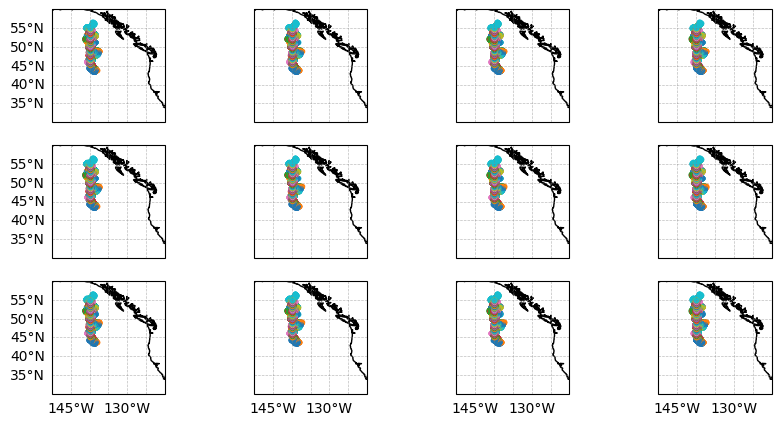

In [21]:
fig: "Figure"
fig, axs = plt.subplots(3, 4, figsize=(10, 5), sharex=True, sharey=True, subplot_kw={"projection": ccrs.PlateCarree()})
axs = cast("AxesArray[GeoAxes]", axs)

for i, d in enumerate(ds):
    ax = axs[i // 4, i % 4]
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in linestrings")
        ax.plot(
            d.lon.T,
            d.lat.T,
            transform=ccrs.PlateCarree(),
            marker=".",
        )
    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent([-150, -120, 30, 60], crs=ccrs.PlateCarree())
    gl = ax.gridlines(linewidth=0.5, color="gray", alpha=0.5, linestyle="--")
    if i % 4 == 0:
        ax.set_ylabel("Latitude (°N)")
        gl.left_labels = True
    if i // 4 == 2:
        ax.set_xlabel("Longitude (°W)")
        gl.bottom_labels = True